In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../src')
from data_loader import load_data

In [49]:
# RBA quarterly inflation rates from 1922
csv_url = 'https://www.rba.gov.au/statistics/tables/csv/g1-data.csv'
local_file = '../data/g1-data.csv'
max_age_days = 1
# First 10 rows are descriptive header rows
skip_rows = 10

df = load_data(csv_url, local_file, max_age_days, skip_rows)    

Using local file


In [50]:

# GCPIAGYP = Consumer Price Index: All Groups, Percentage change from corresponding quarter of previous year
# df = pd.read_csv(local_file, skiprows=10, encoding='cp1252', usecols=['Series ID', 'GCPIAGYP'])

df.dropna(subset=['Series ID'], inplace=True)
df.tail()

,Series ID,GCPIAG,GCPIAGYP,GCPIEITCYP,GCPIXVIYP,GCPITIYP,GCPITXVIYP,GCPINTIYP,GCPINTXDLYP,GCPIOCPMWMYP,...,GCPIAGSAQP,GCPIEITCQP,GCPIXVIQP,GCPITIQP,GCPITXVIQP,GCPINTIQP,GCPINTXDLQP,GCPIOCPMWMQP,GCPIOCPMTMQP,Unnamed: 21
404,Jun-2023,133.7,6.0,6.0,6.5,4.4,5.8,6.9,6.9,5.4,...,1.0,1.0,1.0,0.8,1.0,1.1,1.1,1.0,1.0,NaN
405,Sep-2023,135.3,5.4,5.4,5.5,3.7,4.1,6.2,6.2,5.2,...,1.0,1.0,0.8,0.4,-0.2,1.3,1.3,1.3,1.2,NaN
406,Dec-2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
407,Mar-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
408,Jun-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
df.rename(columns={'Series ID': 'Date'}, inplace=True)
# source data is in the format 'Jan-1959' %b-%Y
df['Date'] = pd.to_datetime(df['Date'], format='%b-%Y')
df.set_index('Date', inplace=True)

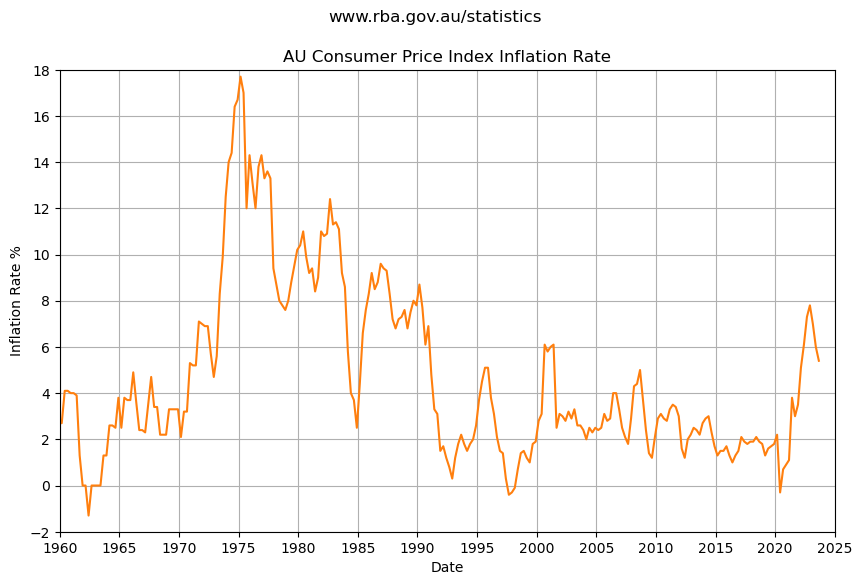

In [52]:
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
start_year = 1960
colors = list(plt.rcParams['axes.prop_cycle'])

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['GCPIAGYP'], color=colors[1]['color'])
plt.xlabel('Date')
plt.ylabel('Inflation Rate %')
plt.suptitle('www.rba.gov.au/statistics')
plt.title('AU Consumer Price Index Inflation Rate')

left_limit = pd.to_datetime(f'{start_year}-01-01')
if start_year >= 1960:
    top_limit = 18
    bottom_limit = -2
    tick_years = 5
else:
    top_limit = 26
    bottom_limit = -14
    tick_years = 10
plt.ylim(bottom=bottom_limit, top=top_limit) 
plt.xlim(left=left_limit, right=pd.to_datetime('2025-01-01'))
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(mdates.YearLocator(tick_years))  # Set major ticks every x years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as years
ax.yaxis.set_major_locator(ticker.MultipleLocator(2)) 

plt.grid(True)
plt.show()

In [53]:
# 4 quarters per year * 3 years = 12 quarters
df['3_yr_rolling'] = df['GCPIAGYP'].rolling(window=12, min_periods=12).mean()
df.tail()

,GCPIAG,GCPIAGYP,GCPIEITCYP,GCPIXVIYP,GCPITIYP,GCPITXVIYP,GCPINTIYP,GCPINTXDLYP,GCPIOCPMWMYP,GCPIOCPMTMYP,...,GCPIEITCQP,GCPIXVIQP,GCPITIQP,GCPITXVIQP,GCPINTIQP,GCPINTXDLQP,GCPIOCPMWMQP,GCPIOCPMTMQP,Unnamed: 21,3_yr_rolling
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-01,133.7,6.0,6.0,6.5,4.4,5.8,6.9,6.9,5.4,5.9,...,1.0,1.0,0.8,1.0,1.1,1.1,1.0,1.0,NaN,4.358333
2023-09-01,135.3,5.4,5.4,5.5,3.7,4.1,6.2,6.2,5.2,5.2,...,1.0,0.8,0.4,-0.2,1.3,1.3,1.3,1.2,NaN,4.750000
2023-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


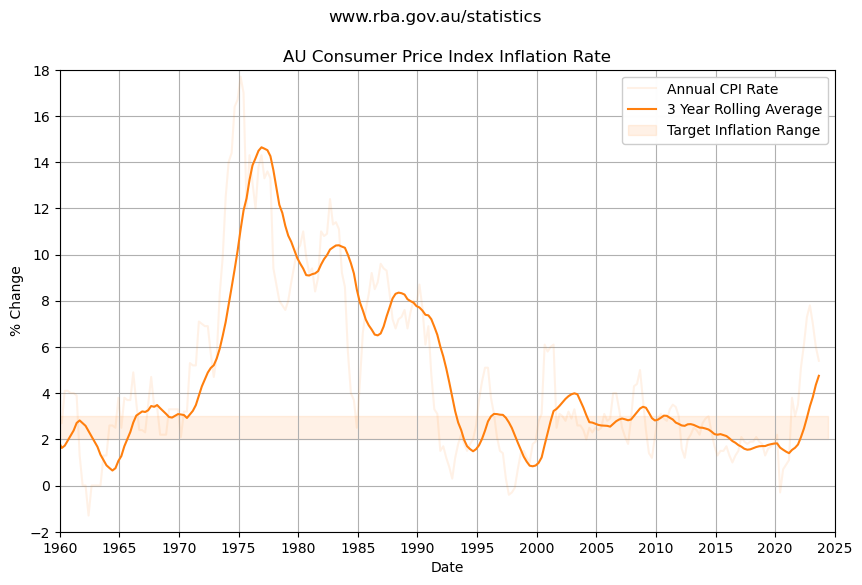

In [54]:
import matplotlib.patches as mpatches

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['GCPIAGYP'], label='Annual CPI Rate', color=colors[1]['color'], alpha=0.1)
plt.plot(df.index, df['3_yr_rolling'], label='3 Year Rolling Average', color=colors[1]['color'])
plt.xlabel('Date')
plt.ylabel('% Change')
plt.suptitle('www.rba.gov.au/statistics')
plt.title('AU Consumer Price Index Inflation Rate')
plt.ylim(bottom=bottom_limit, top=top_limit) 
plt.xlim(left=left_limit, right=pd.to_datetime('2025-01-01'))
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(mdates.YearLocator(tick_years))  # Set major ticks every x years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as years
ax.yaxis.set_major_locator(ticker.MultipleLocator(2)) 

plt.grid(True)

# Add a horizontal band between y=2 and y=3
plt.fill_between(df.index, 2, 3, color=colors[1]['color'], alpha=0.1)
# Create a Patch for the legend
target_range = mpatches.Patch(color=colors[1]['color'], alpha=0.1, label='Target Inflation Range')
# Get the existing legend entries
handles, labels = ax.get_legend_handles_labels()
# Add the patch to the existing handles
handles.append(target_range)
# Create the legend with the existing entries and the new patch
legend = plt.legend(handles=handles, loc='best')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.98)
plt.show()